In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyntcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.3/346.3 kB 7.0 MB/s eta 0:00:00


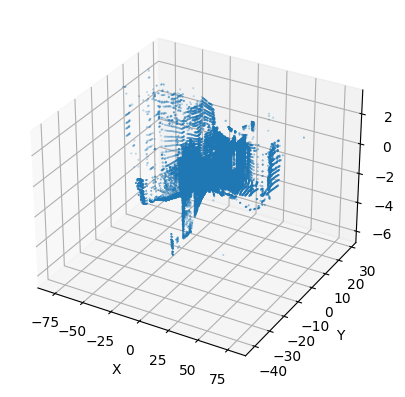

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Path to the .bin file
bin_file = '/content/drive/MyDrive/Colab Notebooks/188/stage3_testing/000000.bin'

# Load the point cloud data from the .bin file
points = np.fromfile(bin_file, dtype=np.float32).reshape(-1, 4)

# Extract X, Y, and Z coordinates
x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

# Plot the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pyntcloud import PyntCloud

# Set paths for dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/188'
point_clouds_path = os.path.join(dataset_path, 'stage3_training')
labels_path = os.path.join(dataset_path, 'stage3_train_labels')

# Preprocessing parameters
test_size = 0.2  # 20% of data will be used for testing
random_seed = 42

# Load point clouds
point_cloud_files = sorted(os.listdir(point_clouds_path))
point_clouds = []
for file in point_cloud_files:
    if file.endswith('.bin'):
        file_path = os.path.join(point_clouds_path, file)
        points = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
        point_clouds.append(points)
# point_clouds = np.concatenate(point_clouds, axis=0)

# Load labels
label_files = sorted(os.listdir(labels_path))
labels = []
for file in label_files:
    if file.endswith('.txt'):
        file_path = os.path.join(labels_path, file)
        label_data = pd.read_csv(file_path, header=None, sep=' ')
        labels.append(label_data)

# Split data into training and validation sets
train_pc, val_pc, train_labels, val_labels = train_test_split(point_clouds, labels, test_size=test_size, random_state=random_seed)

ModuleNotFoundError: ignored

In [ ]:
# Find the largest size among all dataframes in label data
largest_size = max(df.shape[0] for df in train_labels)
largest_size2 = max(df.shape[0] for df in val_labels)
largest_size = max(largest_size2,largest_size)

# Pad all dataframes to the largest size
label_data_padded = []
val_data_padded = []
for df in train_labels:
    num_rows_to_pad = largest_size - df.shape[0]
    padding_df = pd.DataFrame([[0] * df.shape[1]] * num_rows_to_pad, columns=df.columns)
    padded_df = pd.concat([df, padding_df], ignore_index=True)
    label_data_padded.append(padded_df)
for df in val_labels:
    num_rows_to_pad = largest_size - df.shape[0]
    padding_df = pd.DataFrame([[0] * df.shape[1]] * num_rows_to_pad, columns=df.columns)
    padded_df = pd.concat([df, padding_df], ignore_index=True)
    val_data_padded.append(padded_df)

In [ ]:
print(train_pc[0].shape)
print(val_pc[0].shape)
print(train_labels[0].shape)
print(val_labels[0].shape)

# Find the smallest size among all arrays in train_data
smallest_size = min(pc.shape[0] for pc in train_pc)
smallest_size2 = min(pc.shape[0] for pc in val_pc)
smallest_size = min(smallest_size2,smallest_size)

# Crop all arrays to the smallest size
train_data_cropped = [pc[:smallest_size, :] for pc in train_pc]
val_data_cropped = [pc[:smallest_size, :] for pc in val_pc]

print(train_data_cropped[0].shape)
print(val_data_cropped[0].shape)

# Remove the fourth channel and resize the elements
train_data_resized = []
for element in train_data_cropped:
    resized_element = element[:, :3]  # Remove the fourth channel
    train_data_resized.append(resized_element)

val_data_resized = []
for element in val_data_cropped:
    resized_element = element[:, :3]  # Remove the fourth channel
    val_data_resized.append(resized_element)

# Convert the resized data back to numpy array
train_data_resized = np.array(train_data_resized)
val_data_resized = np.array(val_data_resized)

# Verify shape
print('Resized train_data shape:', train_data_resized.shape)
print('Resized train_data shape:', train_data_resized.shape)


(117922, 4)
(117543, 4)
(9, 15)
(14, 15)
(96195, 4)
(96195, 4)
Resized train_data shape: (400, 96195, 3)
Resized train_data shape: (400, 96195, 3)


In [ ]:
train_tensor = tf.convert_to_tensor(train_data_resized, dtype=tf.float32)
val_tensor = tf.convert_to_tensor(val_data_resized, dtype=tf.float32)

In [ ]:
label_mapping = {'Car': 0, 'Van': 1, 'Truck': 2, 'Pedestrian': 3, 'Person_sitting': 4, 'Cyclist': 5, 'Tram': 6, 'Miscellaneous': 7, 'Misc': 7, 'DontCare':8, 0: 8}

# Convert training data and labels to tensors
train_labels_np = np.array(label_data_padded)
train_labels_int = train_labels_np.copy()
for k, label in enumerate(train_labels_np):
  for q, lab in enumerate(label[:,0]):
    train_labels_int[k][q,0] = label_mapping[lab]
train_labels_tensor = tf.convert_to_tensor(train_labels_int, dtype=tf.int32)

# Convert validation data and labels to tensors
val_labels_np = np.array(val_data_padded)  # Convert the list of pandas DataFrames to a NumPy array
val_labels_int = val_labels_np.copy()
for k, label in enumerate(val_labels_np):
  for q, lab in enumerate(label[:,0]):
    val_labels_int[k][q,0] = label_mapping[lab]
val_labels_tensor = tf.convert_to_tensor(val_labels_int, dtype=tf.int32)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50

# Create the backbone using ResNet50
backbone = ResNet50(include_top=False, weights='imagenet')

# Define the input layer for the backbone
backbone_input = tf.keras.Input(shape=(None, None, 3))

# Apply the backbone to the input
backbone_output = backbone(backbone_input)

# Define the Mask R-CNN head
mrcnn_head = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(backbone_output)
mrcnn_head = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(mrcnn_head)
# Add more layers as needed for your specific application

# Create the Mask R-CNN model
mrcnn_model = tf.keras.Model(inputs=backbone_input, outputs=mrcnn_head)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
num_points, num_features = (96195, 3)
# Define the input shape of your point cloud data
input_shape = (num_points, num_features)  # Adjust the values based on your data

# Reshape the input data
reshaped_input = tf.keras.Input(shape=input_shape)
expanded_input = tf.expand_dims(reshaped_input, axis=0)

# Create the backbone using ResNet50
backbone = ResNet50(include_top=False, weights='imagenet')
backbone_output = backbone(expanded_input)

# # Flatten the output to be compatible with subsequent layers
# flattened_output = layers.Flatten()(backbone_output)

# # Get the last dimension of the flattened output
# last_dim = flattened_output.shape[-1]

# Define the Mask R-CNN head
mrcnn_head = layers.Dense(256, activation='relu')(backbone_output)
mrcnn_head = layers.Dense(256, activation='relu')(mrcnn_head)

# Create the Mask R-CNN model
mrcnn_model = tf.keras.Model(inputs=reshaped_input, outputs=mrcnn_head)

In [ ]:
# U-Net encoder
encoder_input = tf.keras.Input(shape=(None, None, 256))  # Use the output shape from Mask R-CNN head

# Encoder layers
encoder = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_input)
# encoder = layers.MaxPooling2D((2, 2))(encoder)
encoder = layers.MaxPooling2D(pool_size=(1, 1), strides=(1, 1))(encoder)
# Add more encoder layers as needed for your specific application

# U-Net decoder
# Decoder layers
decoder = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(encoder)
decoder = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(decoder)
decoder = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(decoder)

# U-Net output
unet_output = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder)  # Output with 1 channel for binary segmentation

# Create the U-Net model
unet_model = tf.keras.Model(inputs=encoder_input, outputs=unet_output)


In [ ]:
# Connect the output of the Mask R-CNN head to the input of the U-Net
mrcnn_output = mrcnn_model.output
unet_input = mrcnn_output

# Pass the output of the Mask R-CNN head to the U-Net
unet_output = unet_model(unet_input)

# Create the combined model
combined_model = tf.keras.Model(inputs=mrcnn_model.input, outputs=unet_output)

In [ ]:
# Compile the combined model
combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the combined model
epochs = 10
batch_size = 32

# combined_model.fit(train_data, label_data_padded, validation_data=(val_data, val_data_padded),
#                    batch_size=batch_size, epochs=epochs)
combined_model.fit(train_tensor, train_labels_tensor, validation_split=0.2,
                   batch_size=batch_size, epochs=epochs)

Epoch 1/10


ValueError: ignored